# **MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿**

## **과제 1️⃣**
### 장르별 영화 트렌드 및 흥행 성공 요인 분석

#### 최근 20년간 영화 장르별 트렌드 변화를 분석하고, 각 장르에서 흥행에 성공한 영화들의 공통 요소(예산, 런타임, 출연진, 개봉 시기 등)를 파악하세요.

#### **영화 장르별 트렌드 변화 분석 및 시각화**

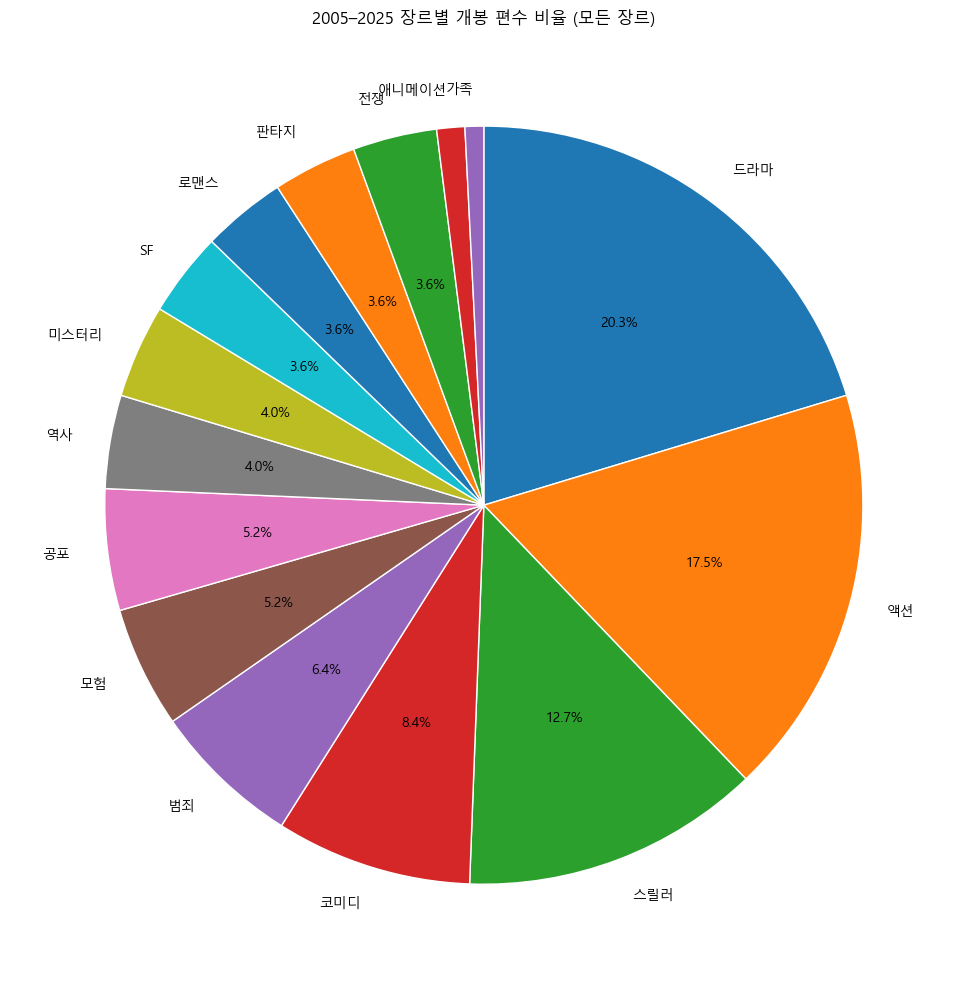


--- 장르별 평균 흥행 지표 시각화 ---


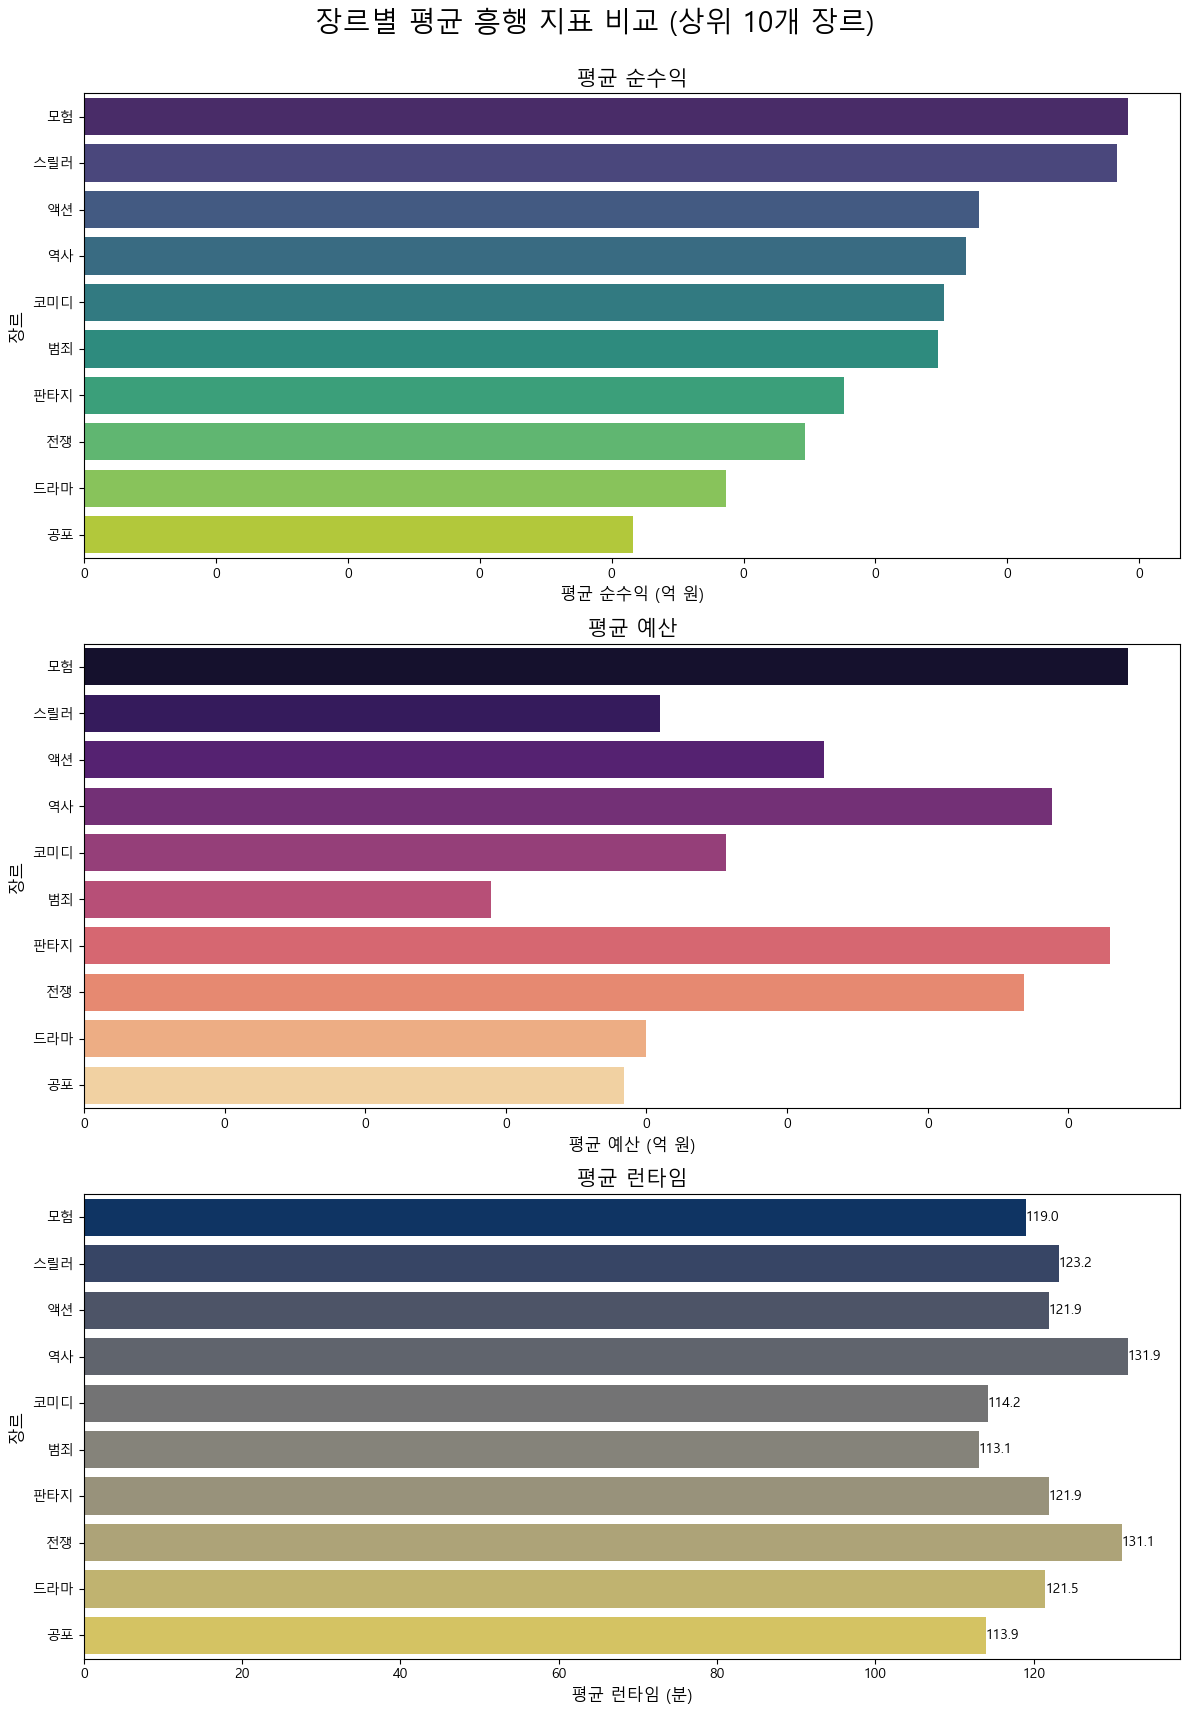


--- 장르별 흥행 영화의 개봉 계절 분포 시각화 ---


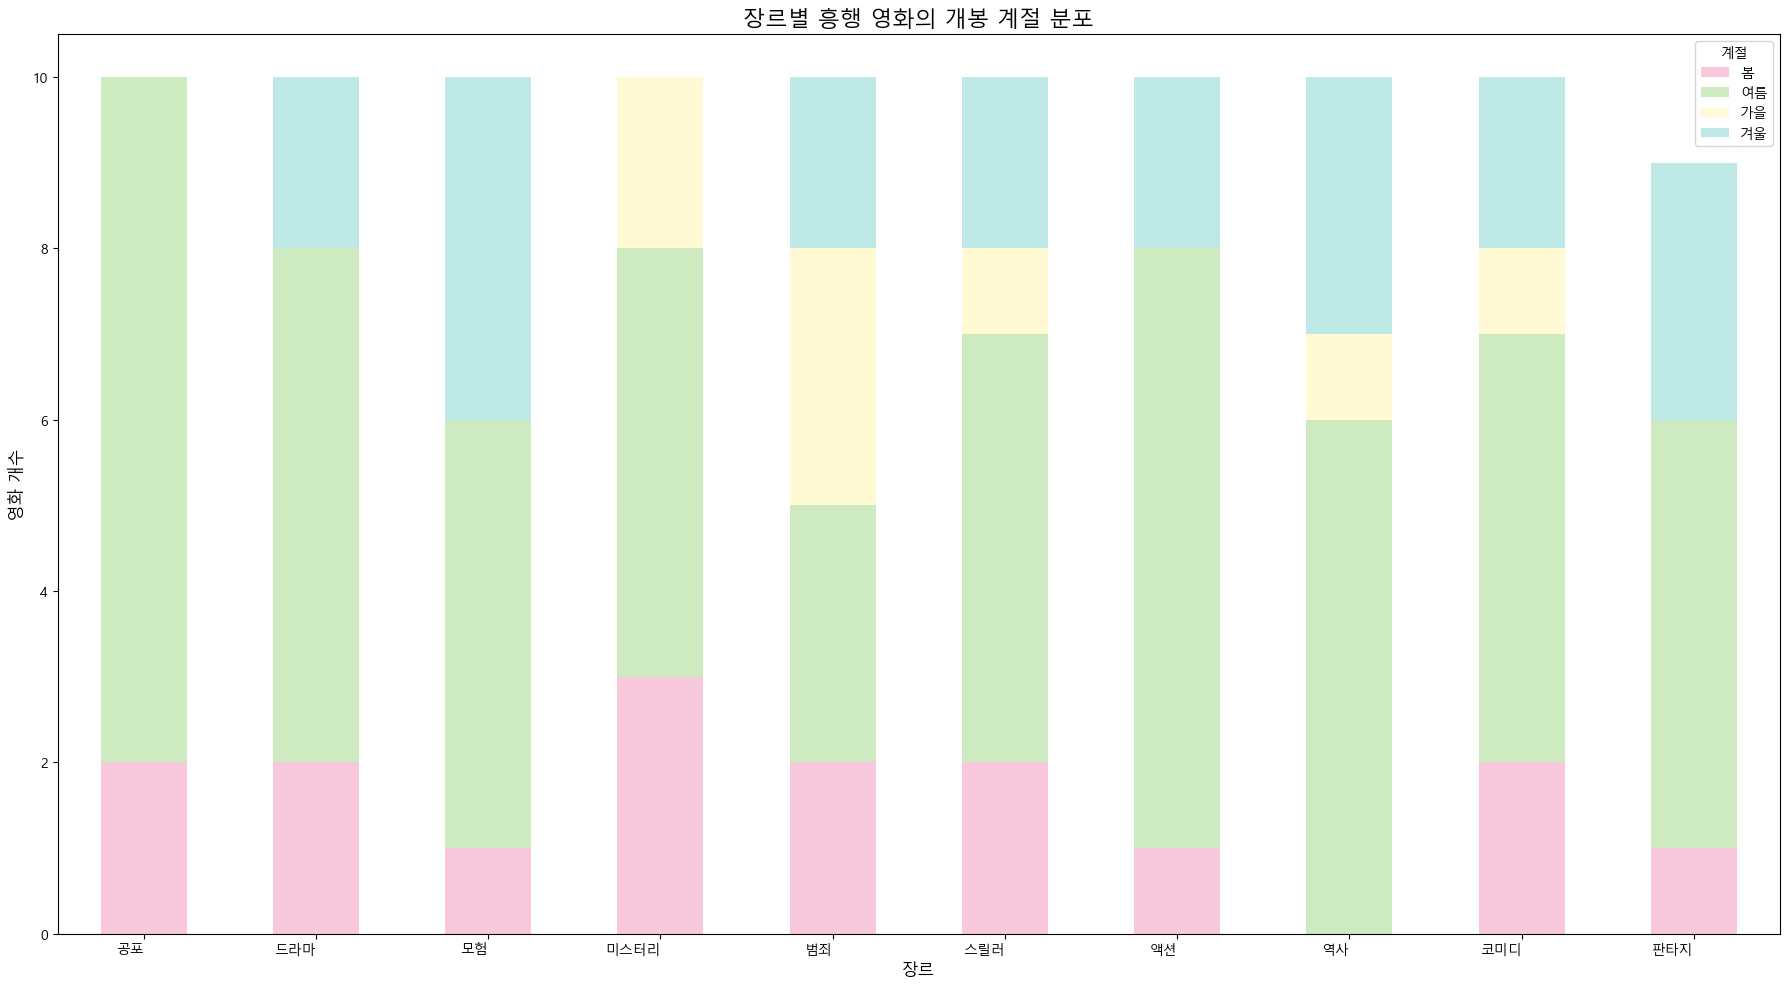

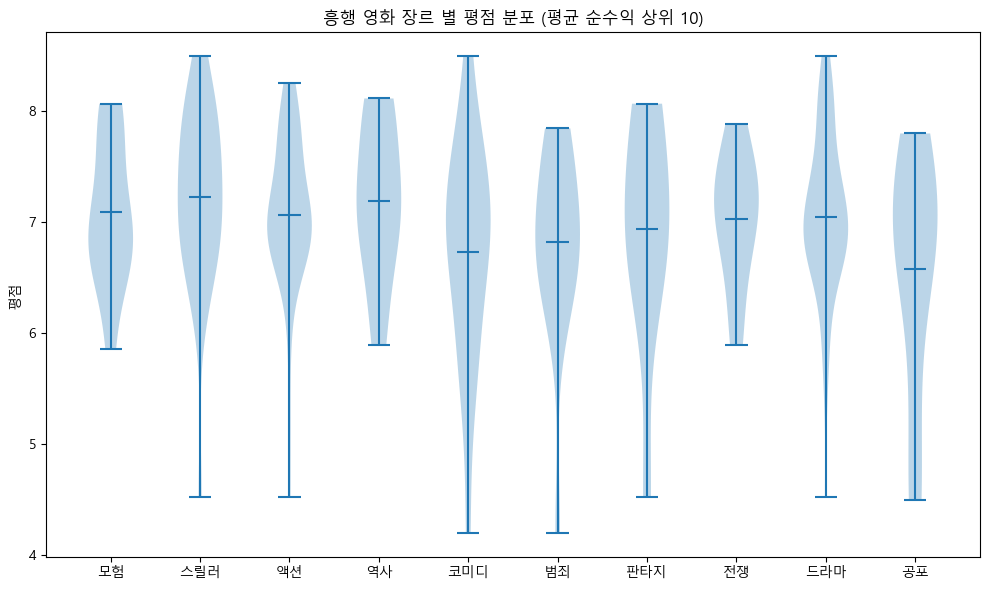

In [ ]:
# === 설정/불러오기 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn 추가
from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

PATH_EXP = "./tmdb_kr_theatrical_clean_exploded.csv"
df = pd.read_csv(PATH_EXP)


# === 1) 20년간 장르 편수: 파이 차트(모든 장르) ===
genre_counts = (df.groupby("genres")["movie_id"]
                .nunique()
                .sort_values(ascending=False))

genre_share = (genre_counts / genre_counts.sum() * 100).round(2)

plt.figure(figsize=(10,10))
def autopct_pct_only(pct, threshold=2.0):
    return f"{pct:.1f}%" if pct >= threshold else ""
plt.pie(
    genre_counts.values,
    labels=genre_counts.index,
    autopct=lambda p: autopct_pct_only(p, threshold=2.0),
    startangle=90, counterclock=False, wedgeprops=dict(edgecolor="white")
)
plt.title("2005–2025 장르별 개봉 편수 비율 (모든 장르)")
plt.tight_layout(); plt.show()


# 'profit' (순수익) 컬럼 계산
df['profit'] = df['revenue'] - df['budget']

# 'release_date'를 datetime 객체로 변환하고 'year' 컬럼 생성
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year

# 월을 계절로 매핑하는 함수
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

# 'release_date'의 월을 기반으로 'season' 컬럼 생성
df['season'] = df['release_date'].dt.month.apply(get_season)

# ======================================================
# 2. 장르별 흥행 요인 시각화 (막대 그래프)
# ======================================================
print("\n--- 장르별 평균 흥행 지표 시각화 ---")

# 장르별로 그룹화하여 평균 순수익, 예산, 런타임 계산
success_factors = df.groupby('genres').agg(
    average_profit=('profit', 'mean'),
    average_budget=('budget', 'mean'),
    average_runtime=('runtime', 'mean'),
    movie_count=('title', 'count')
).reset_index()

# 영화 수가 5개 이상인 장르만 선택하여 분석 신뢰도 높이기
success_factors = success_factors[success_factors['movie_count'] >= 5]
# 평균 순수익 기준으로 상위 10개 장르 선택
top_10_by_profit = success_factors.sort_values(by='average_profit', ascending=False).head(10)

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)
fig.suptitle('장르별 평균 흥행 지표 비교 (상위 10개 장르)', fontsize=20, y=0.95)

# 순수익 막대 그래프
sns.barplot(x='average_profit', y='genres', data=top_10_by_profit, ax=axes[0], palette='viridis', hue='genres', legend=False)
axes[0].set_title('평균 순수익', fontsize=15)
axes[0].set_xlabel('평균 순수익 (억 원)', fontsize=12)
axes[0].set_ylabel('장르', fontsize=12)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/100000000:,.0f}'))

# 예산 막대 그래프
sns.barplot(x='average_budget', y='genres', data=top_10_by_profit, ax=axes[1], palette='magma', hue='genres', legend=False)
axes[1].set_title('평균 예산', fontsize=15)
axes[1].set_xlabel('평균 예산 (억 원)', fontsize=12)
axes[1].set_ylabel('장르', fontsize=12)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/100000000:,.0f}'))

# 런타임 막대 그래프
sns.barplot(x='average_runtime', y='genres', data=top_10_by_profit, ax=axes[2], palette='cividis', hue='genres', legend=False)
axes[2].set_title('평균 런타임', fontsize=15)
axes[2].set_xlabel('평균 런타임 (분)', fontsize=12)
axes[2].set_ylabel('장르', fontsize=12)

# 런타임 값 표시
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.1f')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ======================================================
# 4. 장르별 흥행 영화의 개봉 계절 분포 시각화
# ======================================================
print("\n--- 장르별 흥행 영화의 개봉 계절 분포 시각화 ---")

# 영화 수가 5개 이상인 장르만 선택하여 분석 신뢰도 높이기
genre_counts_filtered = df['genres'].value_counts()
valid_genres = genre_counts_filtered[genre_counts_filtered >= 5].index
df_filtered_genres = df[df['genres'].isin(valid_genres)]

# 각 장르별로 순수익 상위 10개 영화만 추출
top_movies_per_genre = df_filtered_genres.sort_values(by='profit', ascending=False).groupby('genres').head(10).reset_index(drop=True)

# 흥행 영화가 존재하는 상위 10개 장르만 선택
top_10_genres_with_movies = top_movies_per_genre['genres'].value_counts().nlargest(10).index
final_df = top_movies_per_genre[top_movies_per_genre['genres'].isin(top_10_genres_with_movies)]

# 각 장르 내에서 계절별 영화 개수 집계
genre_season_counts = final_df.groupby(['genres', 'season']).size().unstack(fill_value=0)

# 계절 순서 재정렬
genre_season_counts = genre_season_counts[['봄', '여름', '가을', '겨울']]

# 계절에 맞는 색상 팔레트 정의 (파스텔 톤)
seasonal_colors = ['#F8C8DC', '#CDEAC0', '#FFFAD4', '#BEE9E6'] # 봄, 여름, 가을, 겨울

genre_season_counts.plot(kind='bar', figsize=(18, 10), stacked=True, color=seasonal_colors)
plt.title('장르별 흥행 영화의 개봉 계절 분포', fontsize=16)
plt.xlabel('장르', fontsize=12)
plt.ylabel('영화 개수', fontsize=12)
plt.xticks(rotation=0, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='계절', fontsize=10)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# '흥행 영화 장르'의 평점 분포 (바이올린)
# ---------------------------------------------
plt.figure(figsize=(10,6))

# 'top_10_by_profit'에서 장르 리스트 추출
hit_genres = top_10_by_profit['genres'].tolist() 
sel = hit_genres

data = [df.loc[df["genres"]==g, "vote_average"].dropna() for g in sel]
plt.violinplot(data, showmeans=True)
plt.xticks(range(1, len(sel)+1), sel, rotation=0)
plt.title("흥행 영화 장르 별 평점 분포 (평균 순수익 상위 10)")
plt.ylabel("평점")
plt.tight_layout(); plt.show()

#### **장르별 순수익 기준 상위 3개 영화**

In [ ]:
import pandas as pd
from IPython.display import display

# 전처리된 CSV 파일 불러오기
file_path = "tmdb_kr_theatrical_clean_exploded.csv"
try:
    df_movie = pd.read_csv(file_path, encoding='utf-8-sig')
    print("전처리된 파일을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print(f"오류: {file_path} 파일을 찾을 수 없습니다. 'show-full-processed-df' 코드를 먼저 실행하여 파일을 생성해주세요.")
    df_movie = pd.DataFrame()

if not df_movie.empty:
    # 런타임, 예산, 수익이 0인 영화는 제외 (의미있는 데이터만 사용)
    df_movie = df_movie[df_movie['runtime'] > 0]
    df_movie = df_movie[df_movie['budget'] > 0]
    df_movie = df_movie[df_movie['revenue'] > 0]
    
    # 순수익(profit) 컬럼 계산 및 추가
    df_movie['profit'] = df_movie['revenue'] - df_movie['budget']

    # 장르별로 그룹화하여 순수익 기준 상위 3개 영화 추출
    top_movies_per_genre = df_movie.groupby('genres').apply(lambda x: x.nlargest(3, 'profit')).reset_index(drop=True)
    
    print("\n--- 장르별 순수익 기준 상위 3개 흥행 성공 영화 목록과 상세 정보 ---")
    
    # 보기 좋게 장르별로 분리해서 출력합니다.
    for genre in top_movies_per_genre['genres'].unique():
        print(f"\n- 장르: {genre}")
        # 장르에 해당하는 영화들만 필터링
        genre_movies = top_movies_per_genre[top_movies_per_genre['genres'] == genre]
        
        # 'title', 'profit', 'budget', 'runtime', 'release_date' 컬럼만 선택하여 출력합니다.
        # 'profit', 'budget' 컬럼은 더 보기 좋게 포맷합니다.
        genre_movies_display = genre_movies[['title', 'profit', 'budget', 'runtime', 'release_date']].copy()
        
        # 숫자 컬럼을 천 단위 구분 기호와 '원'을 추가하여 포맷
        genre_movies_display['profit'] = genre_movies_display['profit'].apply(lambda x: f"{x:,.0f}원")
        genre_movies_display['budget'] = genre_movies_display['budget'].apply(lambda x: f"{x:,.0f}원")
        
        # display() 함수를 사용하여 표 형태로 출력
        display(genre_movies_display)



전처리된 파일을 성공적으로 불러왔습니다.

--- 장르별 순수익 기준 상위 3개 흥행 성공 영화 목록과 상세 정보 ---

- 장르: SF


C:\Users\sec\AppData\Local\Temp\ipykernel_122588\2266442011.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_movies_per_genre = df_movie.groupby('genres').apply(lambda x: x.nlargest(3, 'profit')).reset_index(drop=True)


,title,profit,budget,runtime,release_date
0,괴물,"77,489,643원","11,000,000원",119,2006-07-27
1,설국열차,"47,558,912원","39,200,000원",127,2013-08-01
2,디 워,"43,108,998원","32,000,000원",92,2007-08-01



- 장르: 가족


,title,profit,budget,runtime,release_date
3,넛잡: 땅콩 도둑들,"78,885,527원","42,000,000원",86,2014-01-17
4,레드슈즈,"-9,945,644원","20,000,000원",92,2019-07-25



- 장르: 공포


,title,profit,budget,runtime,release_date
5,부산행,"79,047,518원","8,500,000원",118,2016-07-20
6,괴물,"77,489,643원","11,000,000원",119,2006-07-27
7,디 워,"43,108,998원","32,000,000원",92,2007-08-01



- 장르: 드라마


,title,profit,budget,runtime,release_date
8,기생충,"246,228,776원","11,363,000원",131,2019-05-30
9,명량,"128,842,258원","9,500,000원",128,2014-07-30
10,신과함께-죄와 벌,"107,683,972원","18,300,000원",139,2017-12-20



- 장르: 로맨스


,title,profit,budget,runtime,release_date
11,아가씨,"30,025,000원","8,575,000원",144,2016-06-01
12,내 깡패 같은 애인,"3,414,668원","800,000원",105,2010-05-20
13,라스트 갓파더,"3,300,000원","13,400,000원",103,2010-12-29



- 장르: 모험


,title,profit,budget,runtime,release_date
14,신과함께-죄와 벌,"107,683,972원","18,300,000원",139,2017-12-20
15,신과함께-인과 연,"94,490,210원","18,300,000원",141,2018-08-01
16,범죄도시 2,"93,566,707원","7,600,000원",106,2022-05-18



- 장르: 미스터리


,title,profit,budget,runtime,release_date
17,곡성,"38,900,770원","10,951,000원",156,2016-05-12
18,숨바꼭질,"33,561,505원","1,900,000원",107,2013-08-14
19,마녀,"18,840,302원","5,500,000원",125,2018-06-27



- 장르: 범죄


,title,profit,budget,runtime,release_date
20,극한직업,"116,532,206원","8,120,000원",111,2019-01-23
21,범죄도시 2,"93,566,707원","7,600,000원",106,2022-05-18
22,베테랑,"80,441,770원","7,528,230원",123,2015-08-05



- 장르: 스릴러


,title,profit,budget,runtime,release_date
23,기생충,"246,228,776원","11,363,000원",131,2019-05-30
24,신과함께-죄와 벌,"107,683,972원","18,300,000원",139,2017-12-20
25,신과함께-인과 연,"94,490,210원","18,300,000원",141,2018-08-01



- 장르: 애니메이션


,title,profit,budget,runtime,release_date
26,넛잡: 땅콩 도둑들,"78,885,527원","42,000,000원",86,2014-01-17
27,돼지의 왕,"-129,987원","130,000원",96,2011-11-03
28,레드슈즈,"-9,945,644원","20,000,000원",92,2019-07-25



- 장르: 액션


,title,profit,budget,runtime,release_date
29,명량,"128,842,258원","9,500,000원",128,2014-07-30
30,극한직업,"116,532,206원","8,120,000원",111,2019-01-23
31,신과함께-죄와 벌,"107,683,972원","18,300,000원",139,2017-12-20



- 장르: 역사


,title,profit,budget,runtime,release_date
32,명량,"128,842,258원","9,500,000원",128,2014-07-30
33,택시운전사,"69,107,975원","12,820,005원",137,2017-08-02
34,최종병기 활,"41,000,000원","8,000,000원",122,2011-08-10



- 장르: 전쟁


,title,profit,budget,runtime,release_date
35,명량,"128,842,258원","9,500,000원",128,2014-07-30
36,인천상륙작전,"36,496,532원","12,700,000원",110,2016-07-27
37,안시성,"28,204,280원","13,305,000원",135,2018-09-19



- 장르: 코미디


,title,profit,budget,runtime,release_date
38,기생충,"246,228,776원","11,363,000원",131,2019-05-30
39,극한직업,"116,532,206원","8,120,000원",111,2019-01-23
40,베테랑,"80,441,770원","7,528,230원",123,2015-08-05



- 장르: 판타지


,title,profit,budget,runtime,release_date
41,신과함께-죄와 벌,"107,683,972원","18,300,000원",139,2017-12-20
42,신과함께-인과 연,"94,490,210원","18,300,000원",141,2018-08-01
43,해적: 바다로 간 산적,"51,400,000원","13,000,000원",129,2014-08-06
